In [1]:
import numpy as np
import datetime
from mantle_utils.workflow.enqueue import get_raster_stack_paths_and_metadata
from mantle_utils.workflow.process import sanitize_raster_stack_paths_and_metadata
from mantle_utils.workflow.metadatadb.product import ProductCollection
from mantle_utils.workflow.metadatadb.product import create_s2_tile_idx_search_dict
from mantle_utils.workflow.metadatadb.product import create_datetime_search_dict
import pandas as pd


In [2]:
stacking_source_run_name = 'nirlipta_30UXB_stack'
tile_idx = '30UXB'

stack_raster_paths, stack_metadata = \
    get_raster_stack_paths_and_metadata(
        env_name='production',
        stacking_source_run_name=stacking_source_run_name,
        tile_idx=tile_idx,
        raise_on_inconsistent_stack=False)
   
stack_df = sanitize_raster_stack_paths_and_metadata(
    raster_paths=stack_raster_paths,
    stack_metadata=stack_metadata,
    sanitize_paths=False)

product_collection = ProductCollection()

product_tile_search_dict = \
    create_s2_tile_idx_search_dict(tile_idx=tile_idx)

stack_df = stack_df[stack_df['source_workflow_name'] == 's1-generate_composites']
sorted_datetimes_asc =[]
sorted_datetimes_dsc =[]
sorted_datetimes = sorted(list(set(
stack_df['start_datetime'].values)))

In [7]:

stack_df.to_pickle('./namelist/s1_alltime.pkl')

In [8]:
for start_datetime_np in sorted_datetimes:
    start_datetime = datetime.datetime.utcfromtimestamp(
        start_datetime_np.astype(int) * 1e-9)

    product_datetime_search_dict = \
        create_datetime_search_dict(
            datetime=start_datetime)
    
    search_dict = {
        'product_metadata.year': start_datetime.year,
        'product_metadata.month': start_datetime.month,
        'product_metadata.day': start_datetime.day,
        **product_tile_search_dict}

    products = product_collection.find_in_db(
        env_name='production',
        projection_dict={
            '_id': 0,
            'product_metadata.pass': 1},
        workflow_name='s1-generate_s2tiles',
        run_name='v1.0-v1.0',
        search_dict=search_dict)

    if products[0]['product_metadata']['pass'] == 'ASCENDING':
        sorted_datetimes_asc.append(start_datetime_np)
    if products[0]['product_metadata']['pass'] == 'DESCENDING':
        sorted_datetimes_dsc.append(start_datetime_np)

In [10]:
dt_sort_a = pd.DataFrame(sorted_datetimes_asc)
dt_sort_d = pd.DataFrame(sorted_datetimes_dsc)
dt_sort_a.to_pickle('./namelist/s1_dates_a.pkl')
dt_sort_d.to_pickle('./namelist/s1_dates_d.pkl')


In [42]:
test = pd.read_pickle('./namelist/s1_dates_a.pkl')

In [43]:
type(test)

pandas.core.frame.DataFrame

In [44]:
test.head()

,0
0,2019-01-02
1,2019-01-04
2,2019-01-08
3,2019-01-09
4,2019-01-10


In [46]:
print(test.columns)
test.columns =['start_time']
print(test.columns)

RangeIndex(start=0, stop=1, step=1)
Index(['start_time'], dtype='object')


In [47]:
test['start_time'] = pd.to_datetime(test['start_time'])

In [48]:
print(test.columns)

Index(['start_time'], dtype='object')


In [2]:
import datetime
import pandas as pd
from statsforecast.adapters.prophet import AutoARIMAProphet
from pathlib import Path
from mantle_utils.alg.raster import Raster
from rasterio.windows import Window
import numpy as np
from multiprocessing import Pool
import itertools
import os.path

In [19]:
df = pd.read_pickle('./namelist/s2_06.pkl')

In [20]:
df

,stack_artefact_name,source_artefact_name,source_run_name,source_workflow_name,start_datetime,end_datetime,raster_path
2612,2612,B06,nirlipta_30UXB,s2-generate_composites,2019-01-02,2019-01-02,s3://mantlelabs-eu-workflows/stacking-generate...
2613,2613,B06,nirlipta_30UXB,s2-generate_composites,2019-01-04,2019-01-04,s3://mantlelabs-eu-workflows/stacking-generate...
2614,2614,B06,nirlipta_30UXB,s2-generate_composites,2019-01-05,2019-01-05,s3://mantlelabs-eu-workflows/stacking-generate...
2615,2615,B06,nirlipta_30UXB,s2-generate_composites,2019-01-07,2019-01-07,s3://mantlelabs-eu-workflows/stacking-generate...
2616,2616,B06,nirlipta_30UXB,s2-generate_composites,2019-01-09,2019-01-09,s3://mantlelabs-eu-workflows/stacking-generate...
...,...,...,...,...,...,...,...
3260,3260,B06,nirlipta_30UXB,s2-generate_composites,2021-12-24,2021-12-24,s3://mantlelabs-eu-workflows/stacking-generate...
3261,3261,B06,nirlipta_30UXB,s2-generate_composites,2021-12-25,2021-12-25,s3://mantlelabs-eu-workflows/stacking-generate...
3262,3262,B06,nirlipta_30UXB,s2-generate_composites,2021-12-27,2021-12-27,s3://mantlelabs-eu-workflows/stacking-generate...
3263,3263,B06,nirlipta_30UXB,s2-generate_composites,2021-12-29,2021-12-29,s3://mantlelabs-eu-workflows/stacking-generate...


In [21]:
raster = Raster(df['raster_path'].values[0])
raster.profile


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5700000.0), 'blockxsize': 64, 'blockysize': 64, 'tiled': True, 'compress': 'deflate', 'interleave': 'band', 'scale': 1.0, 'offset': 0.0}

In [9]:
raster = Raster(df['raster_path'].values[0])
raster.profile


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5700000.0), 'blockxsize': 64, 'blockysize': 64, 'tiled': True, 'compress': 'deflate', 'interleave': 'band', 'scale': 1.0, 'offset': 0.0}

In [10]:
raster.array

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

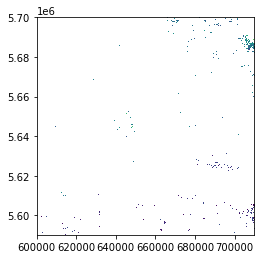

In [11]:
raster.plot()